In [7]:
from pycaret.classification import *


df = pd.read_csv("transformed_df.csv")

#creating a list of the features to be passed onto the setup later
num_cols = list(df.columns)  
num_cols.remove('target')

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,8,4,1,2,0,7,1,0,2,1,8,10,0,0,0,3,0
1,6,9,2,1,0,1,1,0,2,1,8,6,0,0,0,3,0
2,2,2,1,1,0,1,1,1,2,1,8,1,0,0,0,3,0
3,7,1,1,3,0,6,1,0,2,1,8,2,0,0,0,3,0
4,2,11,2,3,0,1,0,0,2,1,8,8,0,0,0,3,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45211 non-null  int64
 1   job        45211 non-null  int64
 2   marital    45211 non-null  int64
 3   education  45211 non-null  int64
 4   default    45211 non-null  int64
 5   balance    45211 non-null  int64
 6   housing    45211 non-null  int64
 7   loan       45211 non-null  int64
 8   contact    45211 non-null  int64
 9   day        45211 non-null  int64
 10  month      45211 non-null  int64
 11  duration   45211 non-null  int64
 12  campaign   45211 non-null  int64
 13  pdays      45211 non-null  int64
 14  previous   45211 non-null  int64
 15  poutcome   45211 non-null  int64
 16  target     45211 non-null  int64
dtypes: int64(17)
memory usage: 5.9 MB


## Checking multicollinearity

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_VIF(x):
  vif= pd.DataFrame()
  vif['variables']=num_cols
  vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
  vif.sort_values('VIF', ascending = False, inplace = True)
  return(vif)


calc_VIF(df[num_cols])

,variables,VIF
15,poutcome,7.061060
10,month,4.933900
2,marital,4.611479
5,balance,3.785615
3,education,3.666364
11,duration,3.305926
0,age,3.214843
9,day,3.125753
1,job,2.781379
6,housing,2.392988


## Holding 5% of the dataset in order to test the final model's power on unseen data

In [12]:
#this should not be confused with a train/test split, it's more of a simulation of  a real life scenario

data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (42950, 17)
Unseen Data For Predictions: (2261, 17)


## Visualizing the balance of the binary target in both datasets

In [48]:
#testing the target shape of both datasets
from collections import Counter

print("--------------- Sampled 95% dataset -------------")
counter = Counter(data['target'])
for k,v, in counter.items():
    dist = v / len(data['target']) * 100
    print(f"Class {k} has {v} samples with {dist:.2f}%")


print("\n-------------- Hold-out dataset (5%) -------------")

counter2 = Counter(data_unseen['target'])
for k,v, in counter2.items():
    dist = v / len(data_unseen['target']) * 100
    print(f"Class {k} has {v} samples with {dist:.2f}%")
#print(data_unseen.groupby('target').count())

--------------- Sampled 95% dataset -------------
Class 0 has 37933 samples with 88.32%
Class 1 has 5017 samples with 11.68%

------------- Hold-out dataset (5%) -------------
Class 0 has 1989 samples with 87.97%
Class 1 has 272 samples with 12.03%


## Setting up the environment

In [13]:
setup_bin = setup(data = data, target = 'target', session_id=50, silent=True, 
                    fix_imbalance = True, remove_multicollinearity = True, 
                    multicollinearity_threshold = 0.95, numeric_features = num_cols)


,Description,Value
0,session_id,50
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(42950, 17)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Comparing the models

In [14]:
#the function  trains and evaluates the performance of all estimators available in the model library using cross-validation
#it can also be ran on Spark or Dask clusters by leveraging the Fugue abstraction layer

best_model = compare_models() #you can also use "probability_threshold = X" for binary classification

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8988,0.9272,0.4913,0.5870,0.5345,0.4783,0.4809,0.4410
xgboost,Extreme Gradient Boosting,0.8985,0.9240,0.4624,0.5915,0.5187,0.4630,0.4676,3.2150
rf,Random Forest Classifier,0.8946,0.9148,0.4307,0.5739,0.4915,0.4341,0.4400,2.4800
et,Extra Trees Classifier,0.8932,0.9059,0.4009,0.5703,0.4703,0.4130,0.4212,1.9970
gbc,Gradient Boosting Classifier,0.8834,0.9084,0.6087,0.5069,0.5528,0.4864,0.4893,3.8520
qda,Quadratic Discriminant Analysis,0.8815,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1170
dummy,Dummy Classifier,0.8815,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1150
ada,Ada Boost Classifier,0.8809,0.8927,0.5940,0.4978,0.5414,0.4736,0.4762,1.0380
dt,Decision Tree Classifier,0.8608,0.6853,0.4534,0.4196,0.4355,0.3563,0.3568,0.1800
knn,K Neighbors Classifier,0.8002,0.8174,0.6943,0.3347,0.4515,0.3471,0.3819,0.7840


# Creating a Light Gradient Boosting Machine model

In [16]:
lgbm = create_model('lightgbm', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8972,0.9272,0.5140,0.5737,0.5422,0.4845,0.4855
1,0.8962,0.9283,0.4663,0.5764,0.5155,0.4582,0.4614
2,0.9022,0.9235,0.5378,0.5981,0.5664,0.5114,0.5124
3,0.8976,0.9255,0.4790,0.5836,0.5262,0.4694,0.4722
4,0.9069,0.9371,0.5056,0.6338,0.5625,0.5111,0.5152
5,0.9045,0.9375,0.5365,0.6102,0.5710,0.5175,0.5189
6,0.8969,0.9229,0.4466,0.5846,0.5064,0.4499,0.4550
7,0.8962,0.9277,0.4831,0.5733,0.5244,0.4666,0.4688
8,0.8935,0.9216,0.4410,0.5647,0.4953,0.4368,0.4409


## Tuning the model

In [17]:
tuned_lgbm = tune_model(lgbm, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8966,0.9229,0.5197,0.5692,0.5433,0.4851,0.4858
1,0.8966,0.9234,0.4888,0.5743,0.5281,0.4704,0.4723
2,0.9006,0.9209,0.5294,0.5906,0.5583,0.5025,0.5035
3,0.8962,0.9194,0.4818,0.5753,0.5244,0.4667,0.4690
4,0.9065,0.9328,0.5197,0.6271,0.5684,0.5165,0.5193
5,0.9005,0.9326,0.4916,0.5973,0.5393,0.4841,0.4870
6,0.8969,0.9176,0.4803,0.5777,0.5245,0.4673,0.4698
7,0.8992,0.9268,0.4916,0.5892,0.5360,0.4800,0.4824
8,0.8952,0.9210,0.4438,0.5745,0.5008,0.4433,0.4479


In [18]:
plot_model(tuned_lgbm, plot = 'parameter')


,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,11
min_child_weight,0.001
min_split_gain,0.4
n_estimators,230


## Checking different plots for the tuned model

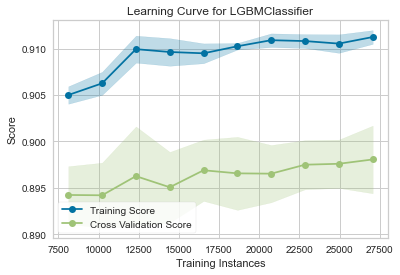

In [19]:
plot_model(estimator = tuned_lgbm , plot= "learning")

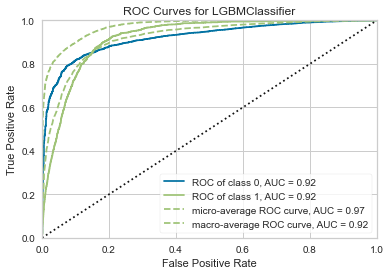

In [20]:
plot_model(tuned_lgbm, plot = 'auc')  #the model is doing good for both classes, even though the dataset is imbalanced

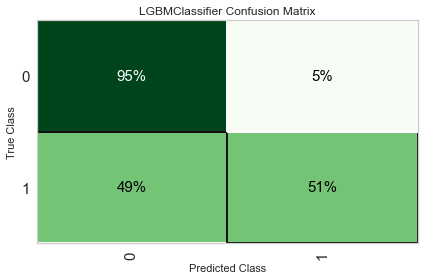

In [21]:
plot_model(tuned_lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

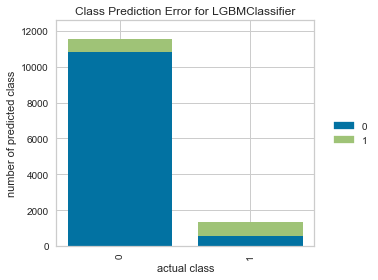

In [22]:
plot_model(estimator = tuned_lgbm, plot = "error")

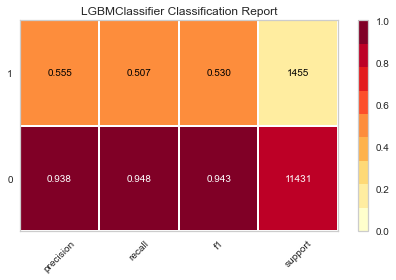

In [23]:
plot_model(estimator = tuned_lgbm, plot = "class_report")

In [35]:
#testing the target shape of train and test target
from collections import Counter

print("------------------ y_test -----------------")
counter = Counter(get_config('y_test'))
for k,v, in counter.items():
    dist = v / len(get_config('y_test')) * 100
    print(f"Class {k} has {v} samples with {dist:.2f}%")


print("------------------ y_train -----------------")

counter2 = Counter(get_config('y_train'))
for k,v, in counter2.items():
    dist = v / len(get_config('y_train')) * 100
    print(f"Class {k} has {v} samples with {dist:.2f}%")
#print(data_unseen.groupby('target').count())

------------------ y_test -----------------
Class 0 has 11431 samples with 88.71%
Class 1 has 1455 samples with 11.29%
------------------ y_train -----------------
Class 0 has 26502 samples with 88.15%
Class 1 has 3562 samples with 11.85%


## Feature importance

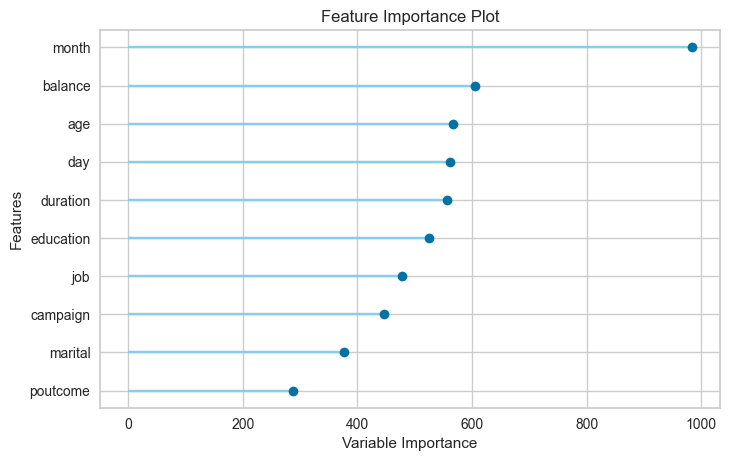

In [25]:
plot_model(estimator = tuned_lgbm, plot = "feature")

## Predicting on the 30% test data

In [26]:
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8985,0.9211,0.5072,0.5553,0.5302,0.4734,0.4740


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target,Label,Score
0,3.0,1.0,2.0,0.0,0.0,6.0,0.0,0.0,2.0,1.0,6.0,1.0,0.0,0.0,0.0,3.0,0,0,0.9958
1,2.0,9.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,6.0,1.0,4.0,0.0,0.0,3.0,0,0,0.9973
2,8.0,9.0,1.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0,7.0,3.0,0.0,0.0,3.0,0,0,0.9697
3,9.0,4.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,1.0,5.0,7.0,0.0,0.0,0.0,3.0,0,0,0.9465
4,2.0,9.0,2.0,1.0,0.0,6.0,1.0,0.0,0.0,1.0,8.0,12.0,1.0,0.0,0.0,0.0,0,0,0.8969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12881,7.0,1.0,1.0,3.0,0.0,5.0,1.0,0.0,2.0,1.0,8.0,8.0,0.0,0.0,0.0,3.0,0,0,0.9957
12882,2.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,1,0,0.9738
12883,8.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,12.0,1.0,0.0,0.0,3.0,1,0,0.7833
12884,2.0,9.0,1.0,1.0,0.0,8.0,1.0,0.0,0.0,2.0,9.0,12.0,3.0,0.0,0.0,1.0,1,0,0.8991


### We get an overall AUC of 0.9211, which corresponds to a (Somer's D) Gini Index of 0.8422, while the accuracy is 90%. Overall, lightgbm serves as an efficient model

## Predicting on the hold-out data

In [27]:
predict_model(tuned_lgbm, data = data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8894,0.9172,0.4522,0.5491,0.4960,0.4345,0.4371


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target,Label,Score
0,2,4,1,2,0,4,1,0,2,1,8,5,0,0,0,3,0,0,0.9962
1,8,9,1,1,0,1,1,0,2,1,8,12,0,0,0,3,0,0,0.9531
2,7,4,0,2,0,0,1,0,2,1,8,10,0,0,0,3,0,0,0.9889
3,7,1,1,3,0,4,1,0,2,1,8,0,0,0,0,3,0,0,0.9975
4,8,9,0,1,0,6,1,0,2,1,8,13,0,0,0,3,0,1,0.6034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,9,11,1,3,0,6,0,0,0,1,9,10,0,0,0,0,0,1,0.5615
2257,0,4,2,1,0,5,1,0,0,1,9,9,0,0,0,2,1,1,0.6835
2258,2,1,1,1,0,3,0,0,0,1,9,9,0,0,0,2,1,1,0.9480
2259,9,5,0,0,0,7,0,0,0,2,9,12,1,0,0,3,1,0,0.6220


### The accuracy and AUC score are esentially the same on the sample we witheld at the beginning
### This confirms that the model does not overfit and can be used for predictions on unseen data

## Model Finalization

### The function fits the model onto the complete dataset including the test/hold-out sample, thus training the model on the complete dataset before production deployment

In [41]:
final_lgbm = finalize_model(tuned_lgbm)

## Saving the model

In [43]:
save_model(final_lgbm, 'lgbm_pipeline')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['age', 'job',
                                                           'marital',
                                                           'education',
                                                           'default', 'balance',
                                                           'housing', 'loan',
                                                           'contact', 'day',
                                                           'month', 'duration',
                                                           'campaign', 'pdays',
                                                           'previous',
 

## Loading and using the saved model

In [44]:
saved_final_lgbm = load_model('lgbm_pipeline')

additional_predictions = predict_model(saved_final_lgbm, data = data_unseen)

additional_predictions.head()

Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8952,0.9221,0.4559,0.5822,0.5113,0.4536,0.4579


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target,Label,Score
0,2,4,1,2,0,4,1,0,2,1,8,5,0,0,0,3,0,0,0.9969
1,8,9,1,1,0,1,1,0,2,1,8,12,0,0,0,3,0,0,0.9721
2,7,4,0,2,0,0,1,0,2,1,8,10,0,0,0,3,0,0,0.9943
3,7,1,1,3,0,4,1,0,2,1,8,0,0,0,0,3,0,0,0.9983
4,8,9,0,1,0,6,1,0,2,1,8,13,0,0,0,3,0,1,0.5101


In [ ]:
#EDA using autoviz

#eda(display_format = 'bokeh')


In [49]:
#dashboard(tuned_log_reg)


In [50]:
# use the following line in the terminal at the end to export package requirements for reproducible results : pip freeze > requirements.txt
